# Fit the geometry and index grains from a single scan

In [1]:
#Export an evironment variable related to SLURM
%env SLURM_CPUS_PER_TASK=7

env: SLURM_CPUS_PER_TASK=7


In [2]:
import h5py, hdf5plugin
import os
import ImageD11.sinograms.dataset, ImageD11.sinograms.properties
import ImageD11.unitcell
import matplotlib.pyplot as plt
%matplotlib widget

#### Set parameters

In [3]:
sample='SiMo1000_6_v2'
scan_name = '05_0N_3DXRD'
scan_id = '5.1'
analysisroot ='/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam'
parfile = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/bccFrelon_unfitted.par'

splinefile = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/frelon36.spline'


#### Fit the geometry using one scan

In [4]:
h5ds = os.path.join(analysisroot,sample,f'ds_{scan_name}.h5')
h5peaks = os.path.join(analysisroot,sample,f'pks_{scan_name}_{scan_id}.h5')
ds = ImageD11.sinograms.dataset.load(h5ds)
pks_table = ImageD11.sinograms.properties.pks_table.load(h5peaks)

In [5]:
pks_2d_dict = pks_table.pk2d(ds.omega,ds.dty) #peaks on each frame
pks_3d_dict = pks_table.pk2dmerge(ds.omega,ds.dty) #merge peaks in omega (and dty) TODO: this might be able to merge in z
print(f"{len(pks_2d_dict['s_raw'])} unmerged peaks")
print(f"{len(pks_3d_dict['s_raw'])} merged peaks")

796690 unmerged peaks
144606 merged peaks


In [6]:
import ImageD11.blobcorrector
import ImageD11.columnfile
import ImageD11.refinegrains
import ImageD11.transformer
import ImageD11.indexing
import ImageD11.grain
import numpy as np

def tocolf(pks,parfile,splinefile,plot=False):
    #Correct peak positions using the spline file
    #preallocate sc and fc in the dictionary
    pks['sc']=np.zeros(len(pks['f_raw']))
    pks['fc']=np.zeros(len(pks['f_raw']))
    corrector = ImageD11.blobcorrector.correctorclass(splinefile)
    for i in range(len(pks['sc'])):
        pks['sc'][i],pks['fc'][i]=corrector.correct(pks['s_raw'][i],pks['f_raw'][i])
    #make a columnfile object
    cf = ImageD11.columnfile.colfile_from_dict(pks)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    if plot:
        fig,ax = plt.subplots(1,3)
        ax[0].scatter(cf.tth,cf.eta,s=0.001)
        ax[0].set_xlabel(r'$2\theta$')
        ax[0].set_ylabel(r'$\eta$')
        ax[1].scatter(cf.eta,cf.omega,s=0.001)
        ax[1].set_xlabel(r'$\eta$')
        ax[1].set_ylabel(r'$\omega$')
        ax[2].scatter(cf.omega,cf.tth,s=0.001)
        ax[2].set_xlabel(r'$\omega$')
        ax[2].set_ylabel(r'$2\theta$')

        # fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        # ax.scatter(cf.tth,cf.eta,cf.omega,s=0.001)
        # ax.set_xlabel(r'$2\theta$')
        # ax.set_ylabel(r'$\eta$')
        # ax.set_zlabel(r'$\omega$')

    return cf

def select_strongest_peaks(colf, frac = 0.99, B=0.2,plot=False):
    #We will keep peaks corresponding to frac of the total intensity

    #This is a correction which I do not quite understand. 
    cor_intensity = colf.sum_intensity*np.exp(B*colf.ds**2)
    #Correct with Lorentz factor
    lf = ImageD11.refinegrains.lf(colf.tth,colf.eta)
    cor_intensity *= lf
    order = np.argsort(cor_intensity)[::-1] #sort the intensity in decreasing order
    sorted_intensity = cor_intensity[order]
    cums = np.cumsum(sorted_intensity)
    cums /= cums[-1] #scale to [0,1]
    #Find the index where the cumsum>frac
    enough = np.searchsorted(cums,frac)
    threshold = sorted_intensity[enough] #The lowest intensity value to keep
    mask = sorted_intensity > threshold
    print(f'Keeping {mask.sum()} strongest peaks')
    if plot:
        fig,ax = plt.subplots(1,2)
        ax[0].plot(cums,',')
        ax[0].set_xlabel('Number of peaks')
        ax[0].set_ylabel('Fractional cumulative intensity')
        ax[0].plot(mask.sum(),frac,'ro')
        ax[1].plot(colf.tth,colf.eta,',')
        ax[1].plot(colf.tth[mask],colf.eta[mask],',')
        ax[1].set_xlabel(r'$2\theta$')
        ax[1].set_ylabel(r'$\eta$')
    return mask

def fit_geometry(colf,parfile,nfits=6):
    colf.writefile('temp.h5') #save the columnfile to a file so that it can be read by transformer
    tr = ImageD11.transformer.transformer(parfile=parfile,fltfile='temp.h5')
    tr.updateparameters()
    plt.figure()
    plt.plot(colf.tth,colf.eta,',',label='Original')
    [tr.fit() for i in range(nfits)]
    tth,eta = tr.compute_tth_eta()
    plt.plot(tth,eta,',',label='Fitted')
    plt.plot(tr.theorytth,[0]*len(tr.theorytth),'|',ms=50)
    plt.legend()
    print('Fitted parameters:')
    for key,val in tr.parameterobj.get_parameters().items():
        print(key, val)
    #save fitted parameters
    outname = parfile.replace('.par','_fitted.par')
    tr.saveparameters(outname)
    #update the colf
    colf.updateGeometry(tr.parameterobj)
    return colf, outname

def index(colf,
          max_multiplicity = 10,
          ds_tol = 0.01,
          max_grains=1000,
          npk_tol = [(200,0.02), (100,0.03)]):
    indexer = ImageD11.indexing.indexer_from_colfile(colf,
                                                     ds_tol=ds_tol,
                                                     max_grains=max_grains)
    indexer.assigntorings()
    indexer.hits=[]
    #find the low multiplicity rings
    rings=[]
    for i,d in enumerate(indexer.unitcell.ringds):
        if len(indexer.unitcell.ringhkls[d])<max_multiplicity:
            rings.append(i)
    for minpks, tol in npk_tol:
        indexer.minpks = minpks
        indexer.hkl_tol = tol
        for indexer.ring_1 in rings[::-1]:
            for indexer.ring_2 in rings[::-1]:
                indexer.find()
                if len(indexer.hits):
                    indexer.scorethem()
        #indexer.score_all_pairs(npairs)
    indexer.fight_over_peaks()
    return indexer

def plot_indexing(indexer,colf):
    indexer.histogram_drlv_fit()
    fig,ax = plt.subplots(1,3)
    for grh in indexer.histogram:
        ax[0].plot(indexer.bins[1:-2],grh[:-2])
    ax[0].set(ylabel='Number of peaks', xlabel='HKL - int(HKL)')
    m = indexer.ga == -1 #not indexed peaks
    ax[1].plot(colf.tth[~m],colf.eta[~m],'.',label='Indexed',alpha=0.5)
    ax[1].plot(colf.tth[m],colf.eta[m],'.',label='Not indexed',alpha=0.5)
    ax[1].legend()
    ax[2].hist(indexer.gas.T)
    ax[2].set(xlabel='Number of indexed peaks', ylabel='Number of grains')

def check_indexed_peaks(indexer,colf,hkl_tol=0.03,plot=False):
    gv = np.transpose((colf.gx,colf.gy,colf.gz)).copy() #array of g-vectors
    n = len(gv) #number of g-vectors
    drlv2 = np.full(n,2,dtype=float) #array of error metric
    labels = np.full(n,-1,'i') #label for g vectors according to grain
    grains = [ImageD11.grain.grain(ubi.copy()) for ubi in indexer.ubis] #array of grain objects
    print(f'The indexer contains {len(grains)} grains')
    for i, g in enumerate(grains): #for each grain
        g.alln = ImageD11.cImageD11.score(g.ubi,gv,hkl_tol) #number of g-vector that indexes the current grain
        npk = ImageD11.cImageD11.score_and_assign(g.ubi,gv,hkl_tol,drlv2, labels, i) #assigns labels and drlv2 to the grain if the drlv2 improves
        labels_free = np.full(n,-1,'i') #let the grain choose peaks freely
        drlv2_free= np.full(n,2,dtype=float) #array of error metric
        npk = ImageD11.cImageD11.score_and_assign(g.ubi,gv,hkl_tol,drlv2_free, labels_free, i) #assign peaks freely
        g.allpks = labels_free == i #these peaks where chosen
        g.isum = colf.sum_intensity[g.allpks].sum() #total intensity of the chosen reflections
    for i,g in enumerate(grains):
        g.pks = labels==i #these are the peaks belonging to grain i 
        g.npks = g.pks.sum()
        hkl_r = np.dot(g.ubi,gv[g.pks].T) #hkl (float) of the indexed peaks
        hkl_i = np.round(hkl_r).astype(int) #hkl rounded to integers
        uniqpks = np.unique(np.vstack((hkl_i,np.sign(colf.eta[g.pks]).astype(int))),axis=1) #find unique hkl combination or ones with different eta (not sure why eta)
        g.nuniq = uniqpks.shape[1] #number of unique peaks in this grain
    if plot:
        Imax = np.max([g.isum for g in grains])
        fig,ax = plt.subplots(1,3)
        ax[0].plot([g.npks for g in grains], [g.nuniq for g in grains],'+')
        ax[0].set(xlabel='Number of peaks', ylabel='Unique peaks')
        ax[1].scatter([g.alln for g in grains], [g.npks/g.alln for g in grains], s=[100*g.isum/Imax for g in grains],c=[i for i in range(len(grains))])
        ax[1].set(xlabel='Number of peaks total', ylabel='Fraction of assigned peaks')
        ax[2].semilogy([g.alln for g in grains], [g.isum for g in grains], '+')
        ax[2].set(xlabel='Number of peaks total', ylabel='Total intensity')
    return grains, labels, drlv2

def domap(  colf,
            grains,
            OmSlop=0.25,
            tolseq = [0.05,0.03,0.01],
            symmetry = 'cubic',
            nuniq = -1,
            npks = 10):
    """
    mapping function - does what makemap.py does, but in a function. More or less verbatim from ImageD11.grid_index_parallel
    """        
    OmFloat= OmSlop > 0
    #
    for tol in tolseq:
        o = ImageD11.refinegrains.refinegrains( OmFloat = OmFloat, OmSlop = OmSlop,
                                       tolerance = tol,
                                       intensity_tth_range = (0,180),
                                       #latticesymmetry = symmetry
                                       )
        o.parameterobj = colf.parameters
        # o.loadfiltered ...
        o.scannames = ["internal"]
        o.scantitles = colf.titles
        o.scandata["internal"] = colf
        o.tolerance = tol
        # o.readubis( grainsfile )
        for i, g in enumerate(grains):
            name = i
            o.grainnames.append(i)
            o.ubisread[name] = g.ubi
            o.translationsread[name] = g.translation
        if symmetry != "triclinic":
            o.makeuniq( symmetry)
        o.generate_grains()
        o.refinepositions()

        # This fills in the uniq for each grain
        o.savegrains( 'nul', sort_npks = False)
        if nuniq >-1:
            keep = lambda g: g.nuniq > nuniq and g.npks > npks
        else:
            keep = lambda g: g.npks > npks
        gl = [ g for g in o.grains.values() if keep(g) ]
        if len(gl) == 0:
            break
        grains = gl

    return gl        




Keeping 12784 strongest peaks


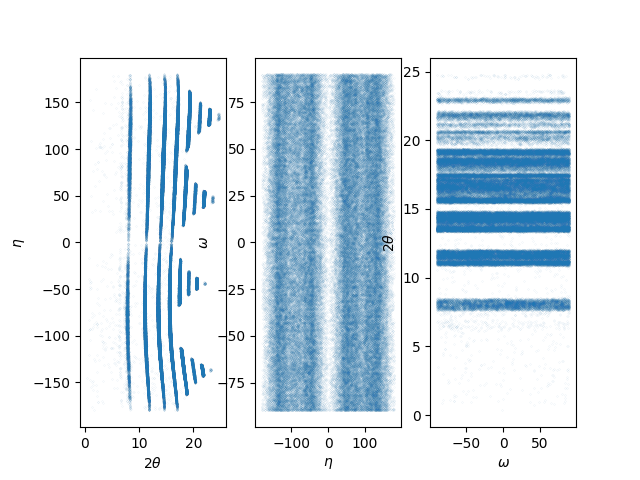

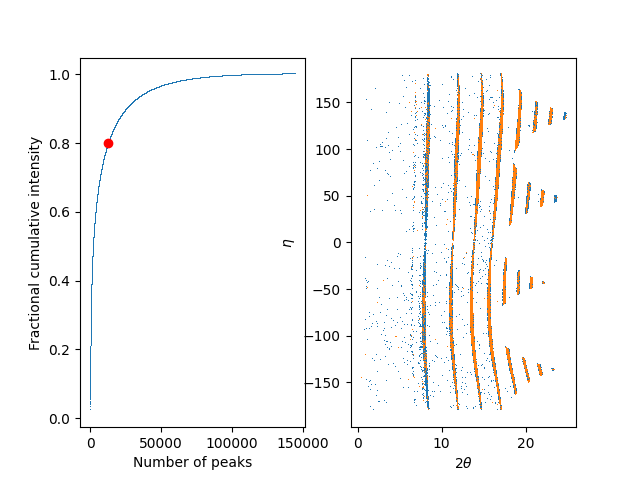

In [9]:
cf = tocolf(pks_3d_dict,parfile,splinefile,plot=True)
mask = select_strongest_peaks(cf,frac=0.8,B=0.2,plot=True)

Text(0, 0.5, '$I_{sum}$')

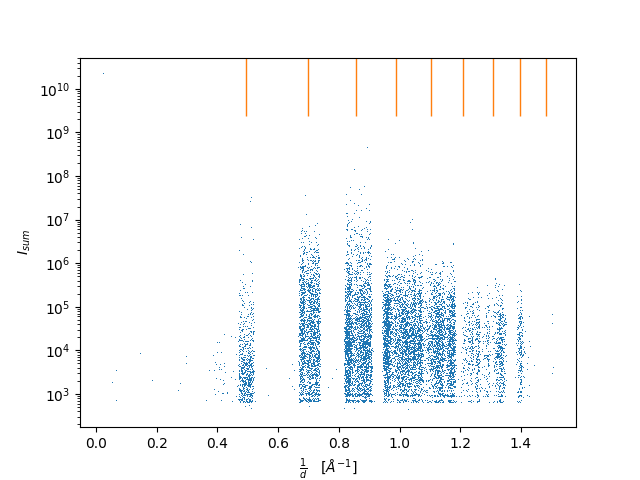

In [10]:
uc = ImageD11.unitcell.unitcell_from_parameters(cf.parameters)
uc.makerings(np.max(cf.ds))
plt.figure()
plt.plot(cf.ds[mask],cf.sum_intensity[mask],',')
plt.plot(uc.ringds,[np.max(cf.sum_intensity[mask])]*len(uc.ringds),'|',ms=60)
plt.semilogy()
plt.xlabel(r'$\frac{1}{d} \quad [Å^{-1}]$')
plt.ylabel(r'$I_{sum}$')


Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 33   Best = 759.494425   Worst = 759.494639                            [1036.3069686622318, 991.1525564882834, 148230.53088995838, -0.10426360656012679, -0.014793141766751453]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 31   Best = 725.703375   Worst = 725.703636                           [1035.5177548408126, 991.0358962690859, 148434.1573404004, -0.08678404776437501, -0.024051020471197407]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 37   Best = 679.318169   Worst = 679.318372                            [1034.9360596825088, 991.1437380700643, 148588.2073874366, -0.07380711703191781, -0.0318589434998883]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 39   Best = 654.907873   Worst = 654.908113                        [1034.405963254963, 991.3684870944078, 148697.01518930524, -0.0645

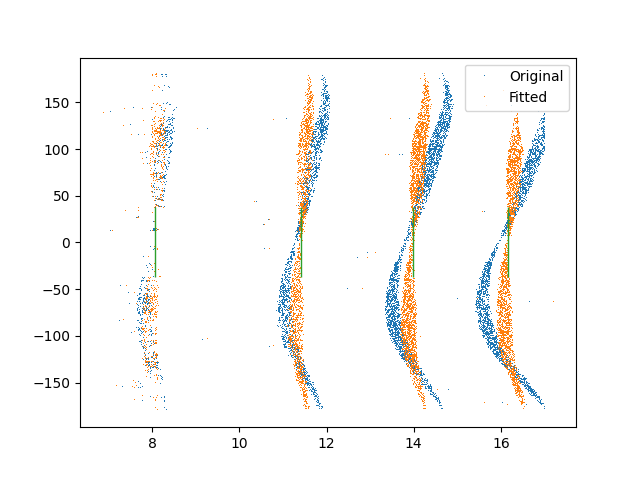

In [11]:
toindex = cf.copy()
toindex.filter(mask) #index only the strong peaks
#keep only the full rings
toindex.filter(toindex.tth>7)
toindex.filter(toindex.tth<17)

#fit the geometry
toindex, fitted_parfile = fit_geometry(toindex,parfile,nfits=10)


### Try to index something

In [12]:
#save the fitted parameters
cf.updateGeometry(toindex.parameters)
indexer = index(toindex,
                max_multiplicity=13,
                ds_tol=0.02,
                max_grains=200,
                npk_tol=[(40,0.01), (30,0.05)])

info: gv: [[-0.03593803 -0.14455448 -0.99752943]
 [-0.14045072 -0.13531934 -0.98778627]
 [-0.16309046 -0.14282442 -0.98160561]
 ...
 [-0.80596353  0.18788931  0.15572399]
 [ 0.74705546 -0.39526868  0.16131265]
 [ 0.86260676 -0.46601588  0.1678173 ]] (8280, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.051437
info: Ring assignment array shape (8280,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 3   ( -2, -2,  0)   12   2591       0     2591   N/A     N/A  16.17
info: Ring 2   ( -2, -1, -1)   24   2963       0     2963   N/A     N/A  13.99
info: Ring 1   ( -2,  0,  0)    6   1956       0     1956   N/A     N/A  11.41
info: Ring 0   ( -1, -1,  0)   12    667       0      667   N/A     N/A  8.06
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (8177, 3)
info: hkls of rings being used for indexing
info: Ring 1: [(-2, -2, 0), (-2, 0, -2), (0, -2, -2), (0, 2,

The indexer contains 10 grains


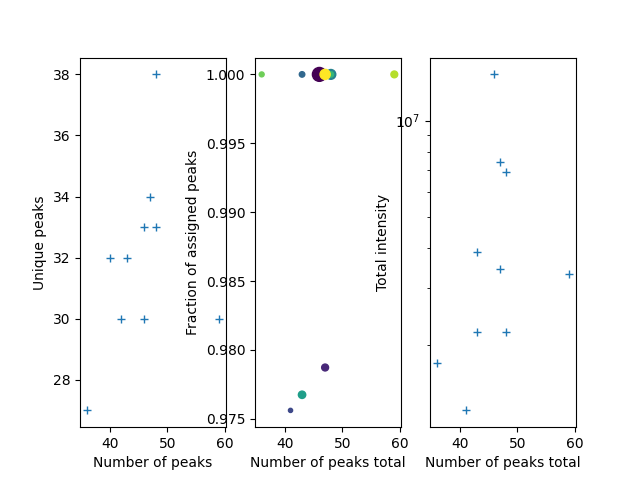

In [13]:
grains,labels, drlv2 = check_indexed_peaks(indexer,cf,plot=True)

#### Save the ubis

In [14]:
%time
h5ubis = os.path.join(analysisroot,sample,f'{scan_name}_{scan_id}_ubis.h5')
cf.addcolumn(labels,'labels')
cf.addcolumn(drlv2,'drlv2')
if os.path.exists(h5ubis):
    !rm {h5ubis} #remove the existing file
ImageD11.columnfile.colfile_to_hdf(cf,h5ubis)
with h5py.File(h5ubis,'a') as hout:
    hout.create_dataset('ubis', data = np.array([g.ubi for g in grains]))
    hout.create_dataset('ubis_allpks', data = np.array([g.allpks for g in grains]))
indexer.saveubis(h5ubis.replace('.h5','.ubi')) #not sure why both are needed

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [15]:
%time
#Running makemap.py
import sys
makemap = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/scripts/makemap.py'
mapname = os.path.join(analysisroot,sample,f'{scan_name}_{scan_id}.map')

run = f"{sys.executable} {makemap} \
        -f {h5ubis} \
        -u {h5ubis.replace('.h5','.ubi')} \
        -U {mapname} \
        -p {fitted_parfile} \
        -t 0.05 --omega_slop=0.25"   
!{run}

run = f"{sys.executable} {makemap} \
        -f {h5ubis} \
        -u {mapname} \
        -U {mapname} \
        -p {fitted_parfile} \
        -t 0.05 --omega_slop=0.25 --no_sort"
!{run}

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Using 0.25 degree slop
got pars
Reading your columnfile in hdf format
DEBUG    : Creating converter from 3 to 5
got filtered
got ubis
generating
resetting labels
Refining posi too
Refining positions too
Assigning labels with XLYLZL
Start first grain loop 0.014338970184326172
0.03994607925415039 First loop
End first grain loop 0.04418015480041504
(144606,) -2 -2
(144606,) -1 9
Start second grain loop 0.0025169849395751953
Grain 0 Scan /Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/05_0N_3DXRD_5.1_ubis.h5 npks= 172
Grain 1 Scan /Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/05_0N_3DXRD_5.1_ubis.h5 npks= 183
Grain 2 Scan /Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/05_0N_3DXRD_5.1_ubis.

In [16]:
%time
#This is for unknown reason a lot slower than running makemap.py
if 1:
    mapped_grains = domap(cf, grains, OmSlop=0.25, tolseq=[0.05])
    mapped_grains = domap(cf, mapped_grains, OmSlop=0.25, tolseq=[0.05])
    mapname = os.path.join(analysisroot,sample,f'{scan_name}_{scan_id}.map')
    ImageD11.grain.write_grain_file(mapname, mapped_grains)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10 µs
Using 0.25 degree slop
resetting labels
Assigning labels with XLYLZL
Start first grain loop 0.013303041458129883
0.036734819412231445 First loop
End first grain loop 0.04087400436401367
(144606,) -2 -2
(144606,) -1 9
Start second grain loop 0.0038568973541259766
Grain 0 Scan internal npks= 172
Grain 1 Scan internal npks= 183
Grain 2 Scan internal npks= 146
Grain 3 Scan internal npks= 201
Grain 4 Scan internal npks= 197
Grain 5 Scan internal npks= 171
Grain 6 Scan internal npks= 179
Grain 7 Scan internal npks= 187
Grain 8 Scan internal npks= 217
Grain 9 Scan internal npks= 195
lorentz per grain for ints tth_per_grain for range 0.00000 180.00000 sum_of_all = 3831431.726712 , middle 168 from 0.000000 to 180.000000 in tth: median = 819.069494 , min = 1.180622 , max = 304122.716180 , mean = 11199.340480 , std = 37218.026702 , n = 168
lorentz per grain for ints tth_per_grain for range 0.00000 180.00000 sum_of_all = 2297103.114749 

No reference lattice parameters supplied. Will use the average of all grains
Average parameters:  [2.8575930143194808, 2.8575930143194808, 2.8575930143194808, 90, 90, 90]


/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/DDDXRD/dddxrd/utils/crystallography.py:99: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(gn[0]/(gn[0]**2+gn[1]**2))


Text(0, 0.5, 'z CoM coordinate')

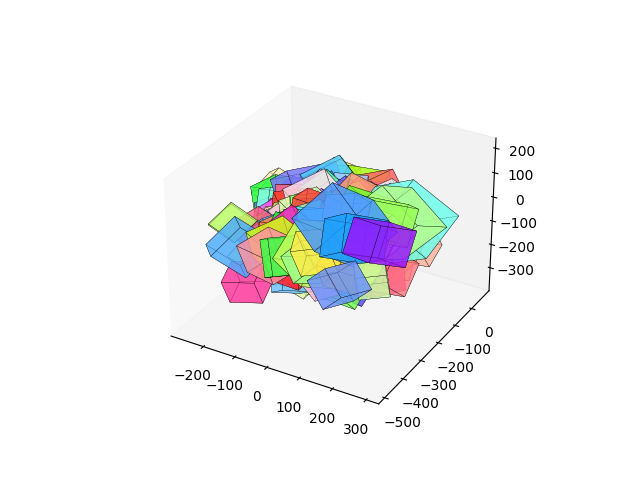

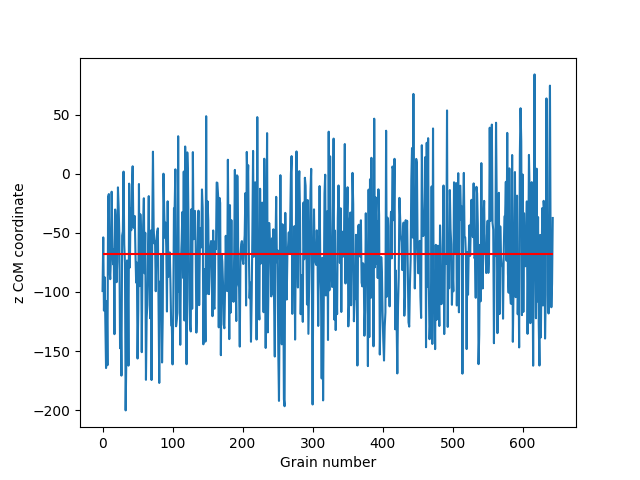

In [21]:
from dddxrd.visualization import Grainmap
gm = Grainmap.Grainmap('/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/script.map')
fig,ax = gm.plot_3d_map()
zs = [g.translation[2] for g in gm.grains]
plt.figure()
plt.plot(zs)
plt.hlines(np.mean(zs),0,len(gm.grains),'r')
plt.xlabel('Grain number')
plt.ylabel('z CoM coordinate')